In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

In [2]:
url = "https://datadocs.bco-dmo.org/file/OJRrAA6hpQREv3/3782_v6_bats_bottle.csv"
df = pd.read_csv(url)
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20T22:30Z,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20T22:30Z,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [3]:
df['datetime'] = pd.to_datetime(df['ISO_DateTime_UTC'], errors="coerce")#.astype('datetime64[s]')
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year,datetime
0,1988-10-20T22:30Z,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311,1988-10-20 22:30:00+00:00
1,1988-10-20T22:30Z,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311,1988-10-20 22:30:00+00:00


In [4]:
def make_depth_datasets(df, depths, time='datetime'):
    
    da = {}
    for min_depth, max_depth, label in depths:

        df_subset = df[(df['Depth'] >= min_depth) & (df['Depth'] <= max_depth)].copy()
        
        df_subset['YearMonthDay'] = pd.to_datetime(df_subset[time]).dt.floor('D')
        # df_subset['YearMonth'] = df_subset[time].dt.strftime('%Y-%m')
        df_subset['YearMonth'] = df_subset[time].dt.to_period('M')
        df_subset['Month'] = df_subset[time].dt.month
        df_subset['Year'] = df_subset[time].dt.year
        
        da[label] = df_subset
        
    return da

In [5]:
depth_ranges = [
    (0, 1000, 'surf')]
da = make_depth_datasets(df, depth_ranges)

In [6]:
da = da["surf"]

In [7]:
def round_depth(df):
    df['depth_p'] = df['Depth'].copy()
    mask = df['depth_p'] > 300
    df.loc[mask, 'depth_p'] = (df.loc[mask, 'depth_p'] // 100) * 100
    return df

In [7]:
def round_depth_50(df):
    df['depth_p'] = df['Depth'].copy()
    
    mask = df['depth_p'] > 300
    
    df.loc[mask, 'depth_p'] = ((df.loc[mask, 'depth_p'] + 25) // 50) * 50
    
    return df

In [8]:
data = round_depth_50(da)
data

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF28_Nanoeuks,yyyymmdd,time,decimal_year,datetime,YearMonthDay,YearMonth,Month,Year,depth_p
12,1988-10-21T04:55Z,1000108112,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,12,...,9,19881021,455,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988,1.0
13,1988-10-21T04:55Z,1000108111,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,11,...,9,19881021,455,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988,10.0
14,1988-10-21T04:55Z,1000108110,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,10,...,9,19881021,455,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988,25.0
15,1988-10-21T04:55Z,1000108109,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,9,...,9,19881021,455,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988,50.0
16,1988-10-21T04:55Z,1000108108,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,8,...,9,19881021,455,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71502,2023-12-14T15:59Z,1041101519,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,19,...,9,20231214,1559,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023,400.0
71503,2023-12-14T15:59Z,1041101520,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,20,...,9,20231214,1559,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023,500.0
71504,2023-12-14T15:59Z,1041101522,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,22,...,9,20231214,1559,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023,600.0
71505,2023-12-14T15:59Z,1041101523,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,23,...,9,20231214,1559,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023,800.0


In [9]:
S_surf = data["Salinity"]
thetao_surf = data["Temp"]
data["oxygen_sat"]= gsw.O2sol_SP_pt(S_surf,thetao_surf)
data["AOU"]= (data["oxygen_sat"] - data["Oxygen"])

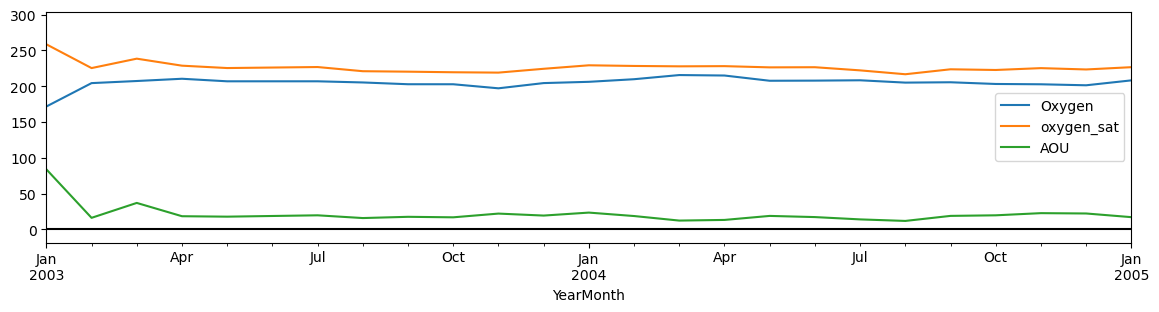

In [10]:
plt.figure(figsize=(14,3))
data.groupby("YearMonth")["Oxygen"].mean().plot(label="Oxygen")
data.groupby("YearMonth")["oxygen_sat"].mean().plot(label="oxygen_sat")
data.groupby("YearMonth")["AOU"].mean().plot(label="AOU")
plt.axhline(y=0, color='k')
plt.xlim(pd.Timestamp(f"2003-01-01"), pd.Timestamp(f"2005-01-01"))
plt.legend()

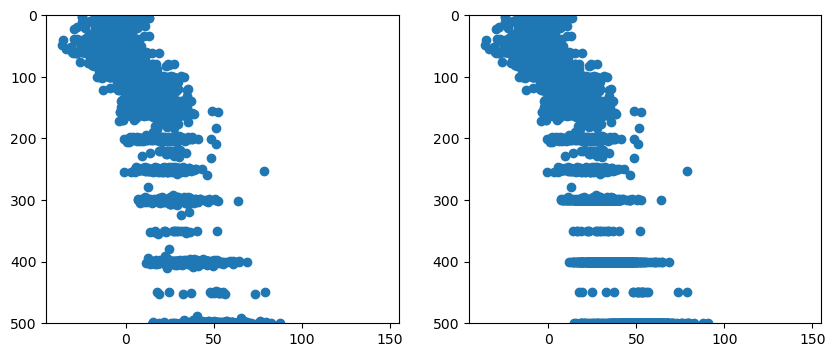

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(data.AOU, data.Depth)
plt.ylim(0,500)
# plt.xlim(2000,2019)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.scatter(data.AOU, data.depth_p)
plt.ylim(0,500)
# plt.xlim(2000,2019)
plt.gca().invert_yaxis()

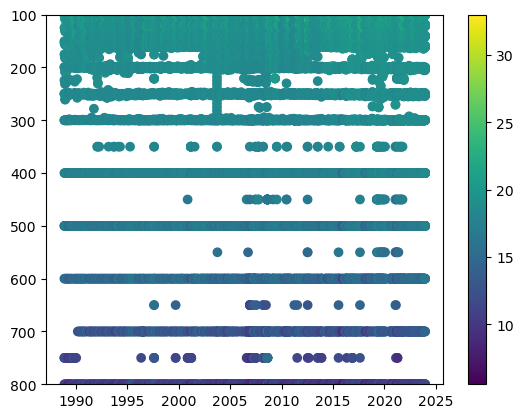

In [17]:
plt.scatter(data.decimal_year, data.depth_p, c=(data['Temp']) , cmap='viridis')#,vmin=160,vmax=220)
plt.ylim(100,800)
# plt.xlim(2005,2007)
plt.colorbar()
# plt.vmax(
plt.gca().invert_yaxis()

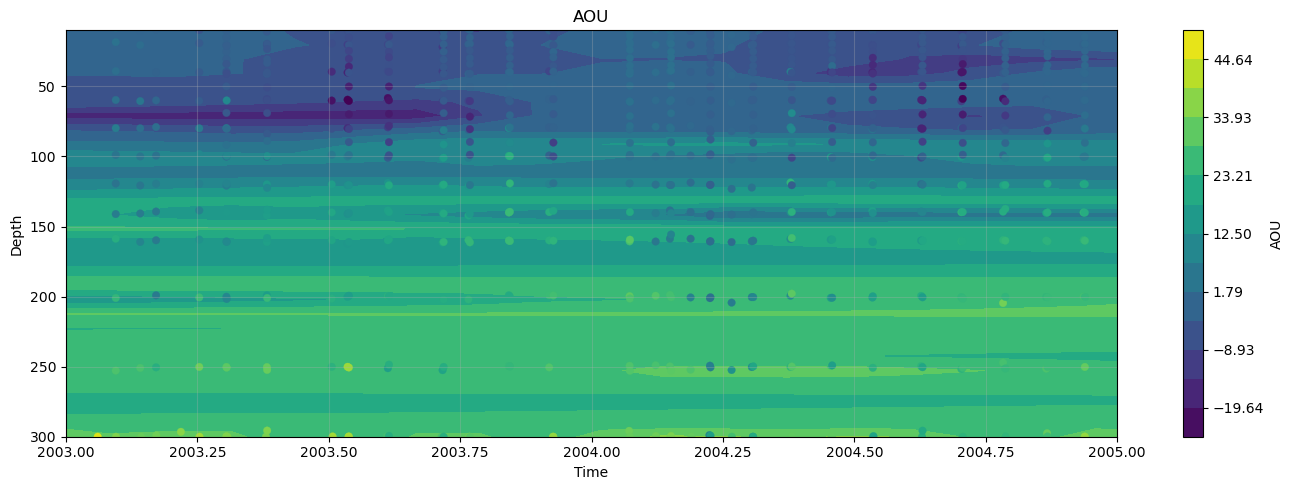

In [62]:
var = 'AOU'
clean_data = data.dropna(subset=[var, 'decimal_year', 'depth_p'])

x = clean_data['decimal_year'].values
y = clean_data['depth_p'].values
z = clean_data[var].values

xi = np.linspace(x.min(), x.max(), 300)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

Z = griddata((x, y), z, (X, Y), method='linear')

# vmin, vmax = np.nanmin(z), np.nanmax(z)
# vmin, vmax = 170, np.nanmax(z)
# vmin, vmax = -20, 40
# vmin, vmax = -28, 50
# vmin, vmax = 15, 30
vmin, vmax = -25, 50
# vmin, vmax = -35, 190

# Define contour levels within that range
levels = np.linspace(vmin, vmax, 15)

plt.figure(figsize=(14, 5))

contour = plt.contourf(X, Y, Z, levels=levels, cmap='viridis',
                       vmin=vmin, vmax=vmax)


plt.scatter(
    clean_data['decimal_year'],
    clean_data['depth_p'],
    c=clean_data[var],
    cmap='viridis',
    norm=mcolors.Normalize(vmin=vmin, vmax=vmax),
    linewidth=0.2,
    s=30
)

plt.colorbar(contour, label=var)

plt.gca().invert_yaxis()
plt.ylim(300, 10)

plt.xlim(2003, 2005)

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title(var)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()